In [1]:
import numpy as np
import pandas as pd
from data_handler import DataHandler
from embed_bins import BinEmbedder
from merge_bins import BinMerger

In [2]:
%matplotlib inline

In [3]:
hr_data = pd.read_csv('data/HR_comma_sep.csv')
hr_data.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'sales', 'salary'],
      dtype='object')

In [4]:
var_dict = dict(
    categorical_vars = ['Work_accident', 'promotion_last_5years', 'sales', 
                        'salary', 'number_project','time_spend_company'],
    numerical_vars = ['satisfaction_level', 'last_evaluation', 'average_montly_hours'],
    class_var = 'left'
)

In [5]:
def split_data(data, val_ratio=0.3):
    idxs = np.arange(0, len(data))
    np.random.shuffle(idxs)
    val_size = int(len(data) * val_ratio)
    train_data = data.iloc[idxs[val_size:]].reset_index(drop=True)
    val_data = data.iloc[idxs[:val_size]].reset_index(drop=True)
    return train_data, val_data

In [6]:
train_data, val_data = split_data(hr_data)

In [7]:
data_handler = DataHandler(train_data, var_dict)
dummy_coded_data = data_handler.get_dummy_coded_data()

In [8]:
dummy_coded_data.shape

(10500, 91)

In [9]:
bin_embedder = BinEmbedder()
bin_embedder.learn_bin_embeddings(dummy_coded_data, data_handler.n_variables)

>>> Iteration = 10000, Loss = 0.21598650515079498
>>> Iteration = 20000, Loss = 0.21387892961502075
>>> Iteration = 30000, Loss = 0.21203020215034485
>>> Iteration = 40000, Loss = 0.2159913033246994
>>> Iteration = 50000, Loss = 0.21459347009658813
>>> Iteration = 60000, Loss = 0.2097788155078888
>>> Iteration = 70000, Loss = 0.21274690330028534
>>> Iteration = 80000, Loss = 0.22057518362998962
>>> Iteration = 90000, Loss = 0.21576601266860962
>>> Iteration = 100000, Loss = 0.212041974067688
>>> Iteration = 110000, Loss = 0.21271030604839325
>>> Iteration = 120000, Loss = 0.21470467746257782
>>> Iteration = 130000, Loss = 0.21674814820289612
>>> Iteration = 140000, Loss = 0.21242579817771912
>>> Iteration = 150000, Loss = 0.21627908945083618
>>> Iteration = 160000, Loss = 0.2117430567741394
>>> Iteration = 170000, Loss = 0.21436262130737305
>>> Iteration = 180000, Loss = 0.21668563783168793
>>> Iteration = 190000, Loss = 0.21492062509059906
>>> Iteration = 200000, Loss = 0.212401673197

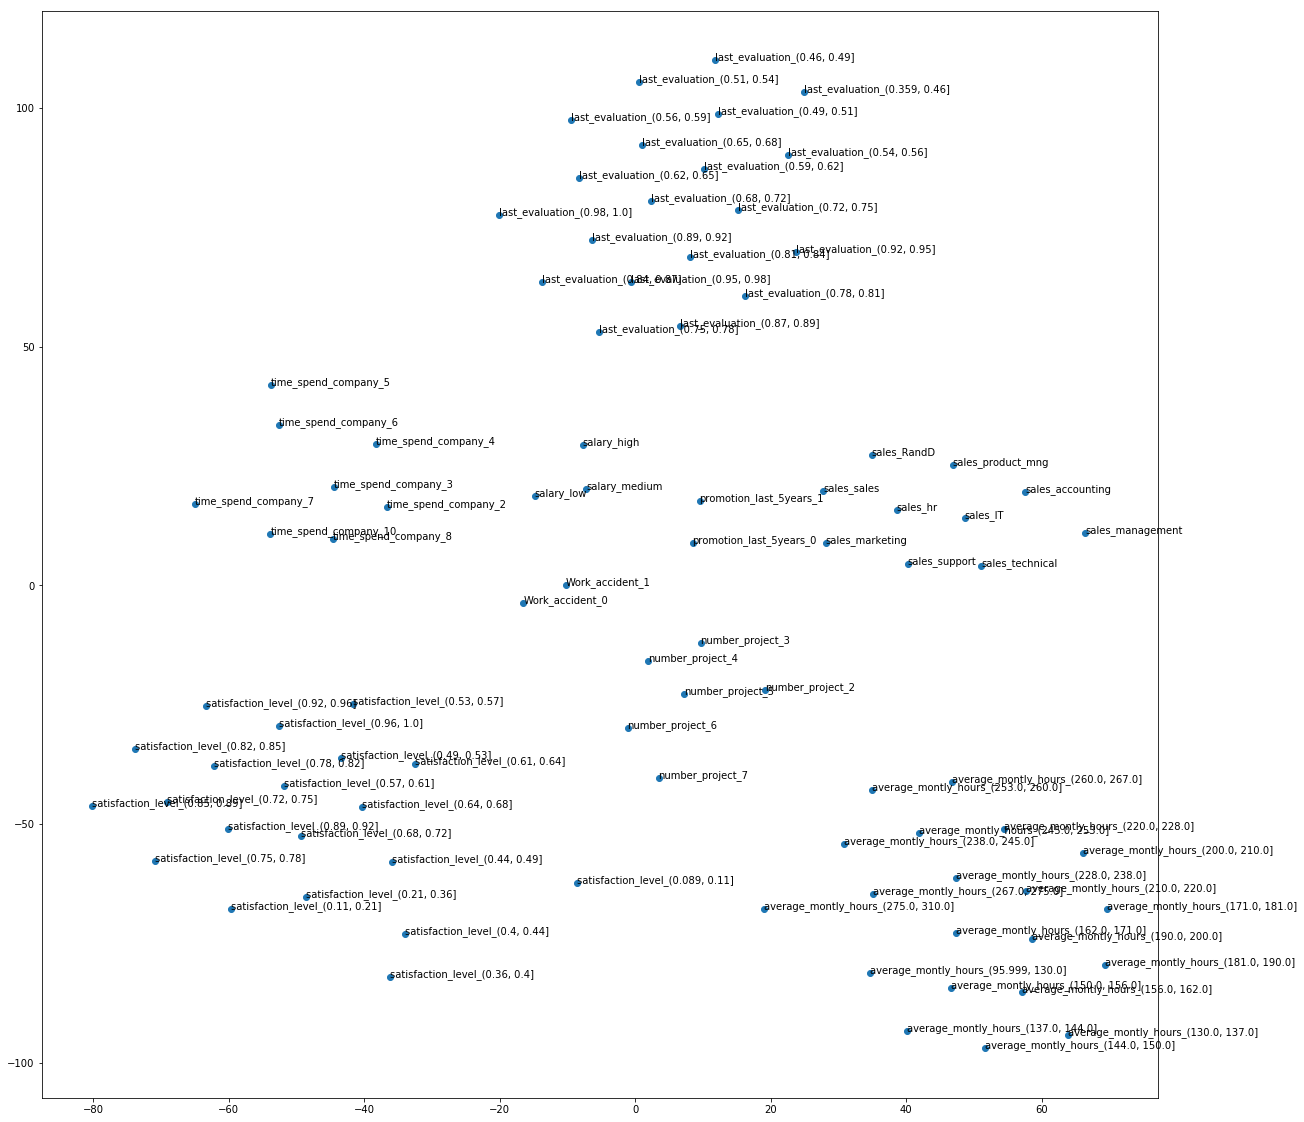

In [10]:
bin_embedder.visualize_embeddings()

In [18]:
bin_merger = BinMerger(bin_embedder.embedding_by_column)
bins_by_var = bin_merger.get_merged_bins_by_var(var_dict)

In [19]:
bins_by_var

{'average_montly_hours': {'merged_bins': ['(130.0, 162.0]',
   '(162.0, 220.0]',
   '(220.0, 238.0]',
   '(238.0, 275.0]'],
  'split_point': [130.0, 162.0, 220.0, 238.0, 275.0]},
 'last_evaluation': {'merged_bins': ['(0.46, 0.59]',
   '(0.59, 0.75]',
   '(0.75, 0.98]'],
  'split_point': [0.46, 0.59, 0.75, 0.98]},
 'satisfaction_level': {'merged_bins': ['(0.11, 1.0]'],
  'split_point': [0.11, 1.0]}}

In [20]:
train_data.satisfaction_level.min()

0.089999999999999997

In [27]:
train_data.average_montly_hours.min()

96

In [21]:
data_handler2 = DataHandler(val_data, var_dict)
semantically_binned_data = data_handler2.get_dummy_coded_data(bins_by_variable=bins_by_var)

In [22]:
semantically_binned_data.columns

Index(['Work_accident_0', 'Work_accident_1', 'promotion_last_5years_0',
       'promotion_last_5years_1', 'sales_IT', 'sales_RandD',
       'sales_accounting', 'sales_hr', 'sales_management', 'sales_marketing',
       'sales_product_mng', 'sales_sales', 'sales_support', 'sales_technical',
       'salary_high', 'salary_low', 'salary_medium', 'number_project_2',
       'number_project_3', 'number_project_4', 'number_project_5',
       'number_project_6', 'number_project_7', 'time_spend_company_10',
       'time_spend_company_2', 'time_spend_company_3', 'time_spend_company_4',
       'time_spend_company_5', 'time_spend_company_6', 'time_spend_company_7',
       'time_spend_company_8', 'satisfaction_level_(0.11, 1.0]',
       'last_evaluation_(0.46, 0.59]', 'last_evaluation_(0.59, 0.75]',
       'last_evaluation_(0.75, 0.98]', 'average_montly_hours_(130.0, 162.0]',
       'average_montly_hours_(162.0, 220.0]',
       'average_montly_hours_(220.0, 238.0]',
       'average_montly_hours_(238.

In [23]:
semantically_binned_data.shape

(4499, 39)

In [24]:
data_handler3 = DataHandler(train_data, var_dict)

In [25]:
equal_freq_binned_data = data_handler3.get_dummy_coded_data()

#### Equal Freq, Width로  train에 대해 구간을 구하고, 이걸 따와서 validation의 구간을 나눠야함

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import cross_val_score

cv_score = cross_val_score(LogisticRegression(), X=dummy_coded_data, y=train_data.left,
                            cv=10, scoring='accuracy', n_jobs=10)
print(cv_score.mean(), cv_score.std())
cv_score = cross_val_score(LogisticRegression(), X=semantically_binned_data, y=val_data.left,
                            cv=10, scoring='accuracy', n_jobs=10)
print(cv_score.mean(), cv_score.std())
print('')

cv_score = cross_val_score(BernoulliNB(), X=dummy_coded_data, y=train_data.left,
                            cv=10, scoring='accuracy', n_jobs=10)
print(cv_score.mean(), cv_score.std())
cv_score = cross_val_score(BernoulliNB(), X=semantically_binned_data, y=val_data.left,
                            cv=10, scoring='accuracy', n_jobs=10)
print(cv_score.mean(), cv_score.std())
print('')

cv_score = cross_val_score(DecisionTreeClassifier(), X=dummy_coded_data, y=train_data.left,
                            cv=10, scoring='accuracy', n_jobs=10)
print(cv_score.mean(), cv_score.std())
cv_score = cross_val_score(DecisionTreeClassifier(), X=semantically_binned_data, y=val_data.left,
                            cv=10, scoring='accuracy', n_jobs=10)
print(cv_score.mean(), cv_score.std())
print('')

/home/taewook/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


0.954383383654 0.00964679661607
0.93642860678 0.010631637016

0.924762602052 0.00619217009291
0.901312051472 0.0124551561632

0.970953913488 0.0054517657537
0.947765404603 0.00912654054039



equal width로 잘라서, 비어 있는 구간이 발생. 임베딩 및 클러스터링 시 문제가 될 수 있음

구간이 노이지한것이 클러스터링 알고리즘 자체의 노이지 함 때문이라면 앙상블 클러스터링으로 해결 가능

그것이 아니라면, 클러스터링이 아니라 인접 구간부터 묶어 나가는 방식의 접근 필요

Binning이 유의미하게 되었는지를 판단하려면, Train data만 보고 구간을 잘라야 함

제대로 안되면 검증 데이터에서 성능 차이가 나야 함

In [26]:
def find_nn(query, candidates, k=10, exclude_self=False):
    embedding_of_query = embedding_by_column[query]
    distances = dict()
    for col, embedding in embedding_by_column.items():
        distances[col] = np.linalg.norm(embedding - embedding_of_query)
    knn = sorted(distances.items(), key=lambda x: x[1])
    if exclude_self:
        knn = knn[1:]
    return knn[:k]

find_nn('average_montly_hours_(150.0, 156.0]', embedding_by_column, k=10)

[('average_montly_hours_(150.0, 156.0]', 0.0),
 ('average_montly_hours_(137.0, 144.0]', 1.203722),
 ('average_montly_hours_(156.0, 162.0]', 1.5114892),
 ('average_montly_hours_(144.0, 150.0]', 1.7245142),
 ('average_montly_hours_(130.0, 137.0]', 2.3776295),
 ('average_montly_hours_(171.0, 181.0]', 2.5450463),
 ('average_montly_hours_(162.0, 171.0]', 2.6919734),
 ('average_montly_hours_(181.0, 190.0]', 2.7010832),
 ('average_montly_hours_(229.0, 238.0]', 2.7029824),
 ('average_montly_hours_(200.0, 210.0]', 2.9372642)]